## 0. References
#### Introduce the engine
- Damage Propagation Modeling.pdf

#### Noise
- RNN: 04711422.pdf
- Auto Encoder: https://www.infoq.com/articles/machine-learning-techniques-predictive-maintenance
- PCA: https://www.infoq.com/articles/machine-learning-techniques-predictive-maintenance
        
#### Feature Engineering
- Moving Average: https://gallery.azure.ai/Experiment/df7c518dcba7407fb855377339d6589f

#### Parameter Setting
- Grid Search: https://www.infoq.com/articles/machine-learning-techniques-predictive-maintenance

#### Models
- LSTM: https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- Kalman Filter: phmc_14_002.pdf

#### Evaluation
- WSO2 CEP: https://www.infoq.com/articles/machine-learning-techniques-predictive-maintenance

#### Process Flow
![title](image/phases.jpg)

## 1. Load Library

In [352]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()

## 2. Data Processing

### 2.a Load the data

In [353]:
# load all files into data, drop the last two columns which are 'na'
allfile = [i+str(j)+'.txt' for i in ['data/'+item for item in ['train_FD00','test_FD00','RUL_FD00']] for j in range(1,4+1)]
data = [pd.read_csv(file, sep=' ', header=None) for file in allfile]
[f.drop(f.columns[[-1, -2]], axis=1, inplace=True) for f in data[0:8]]
header = ['id','cycle'] + ['setting'+str(i) for i in range(1,3+1)] + ['sensor'+str(j) for j in range(1,21+1)]
for k in range(8): data[k].columns = header

In [354]:
# shape of the data sets
pd.DataFrame(np.array([ [np.shape(dd)[0] for dd in data], [np.shape(ff)[1] for ff in data] ]),
                     index=['#columns', '#rows'],
                     columns=[string + str(h) for string in ['train','test','URL'] for h in range(1,4+1)])

,train1,train2,train3,train4,test1,test2,test3,test4,URL1,URL2,URL3,URL4
#columns,20631,53759,24720,61249,13096,33991,16596,41214,100,259,100,248
#rows,26,26,26,26,26,26,26,26,2,2,2,2


In [355]:
# There are certain groups in each train/test data set, review data information in train1
print('train1 groups = ', len(np.unique(data[0]['id'])))
data[0]['cycle'].groupby(data[0]['id']).describe()[0:4]

train1 groups =  100


,count,mean,std,min,25%,50%,75%,max
id,,,,,,,,
1,192.0,96.5,55.569776,1.0,48.75,96.5,144.25,192.0
2,287.0,144.0,82.993976,1.0,72.50,144.0,215.50,287.0
3,179.0,90.0,51.816986,1.0,45.50,90.0,134.50,179.0
4,189.0,95.0,54.703748,1.0,48.00,95.0,142.00,189.0


### 2.b Create Labels

In [356]:
# add columns of rul (remaining useful life), w1 = 30 remaining time series, w2 = 15 remaining time series
for item in data[0:8]:
    item['rul'] = item.groupby('id')['cycle'].transform('max') - item['cycle']
    item['w1'] = np.where(item['rul'] > 30, 0, 1)
    item['w2'] = np.where(item['rul'] > 15, 0, 1)

In [357]:
# assign to separate data sets for easier to manage
train1,train2,train3,train4, test1,test2,test3,test4, RUL1,RUL2,RUL3,RUL4 = data

In [358]:
train1[0:5]

,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,rul,w1,w2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


### 2.c Explore the Data

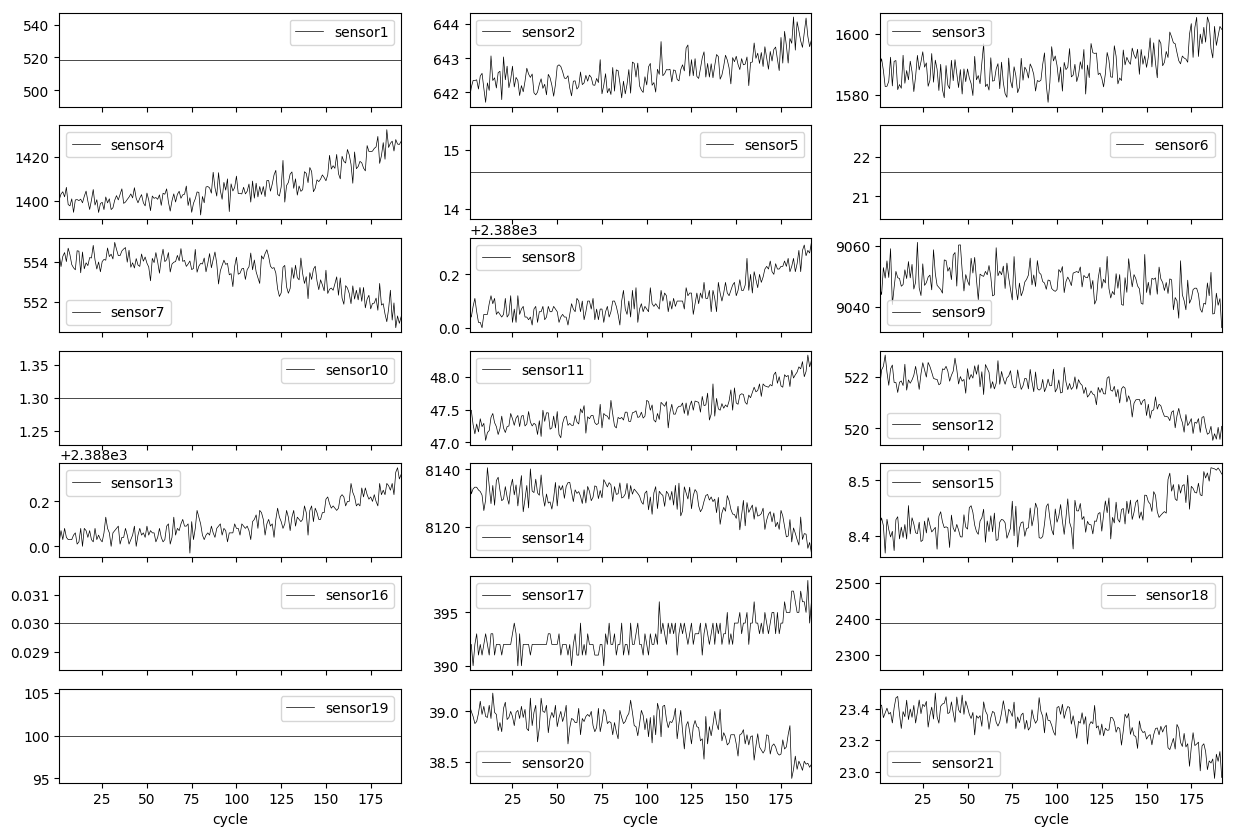

In [359]:
# look at one group of sensor data under train1
_, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
for index, ax in enumerate(axes.ravel()):
    train1[train1['id']==1].plot(x='cycle', y='sensor'+str(index+1), ax=ax, color='black', linewidth=0.5)
plt.show()

In [351]:
# # look at several groups
# _, axes1 = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
# for index1, ax1 in enumerate(axes1.ravel()):
#     for unit_id, group in train1.groupby('id'):
#         (group.plot(x='cycle', y='sensor'+str(index1+1), ax=ax1, color='gray', linewidth=0.5))
#         (group
#             .rolling(window=10, on = 'cycle')
#             .mean()
#             .plot(x='cycle', y='sensor'+str(index1+1), ax=ax1, color='black', legend=False));
# plt.show()
    
# #train1[train1['id']==1].plot(x='cycle', y='sensor'+str(index+1), ax=ax, color='black', linewidth=0.5)